#Stochastic Optimization with QUASAR

In [22]:
from pyquasar import *

## Modeling the Decision Problem

In [23]:
problem = DecisionProblem()

### Decision variables

In [24]:
num_months, release, storage, shortfall = 4, {}, {}, {}
for t in range(num_months):
    release[t], storage[t], shortfall[t] = problem.add_variables(t,'release', 'storage', 'shortfall')

We use >= and <= to model lower and upper bounds.

In [25]:
max_release, max_storage = 2.0, 6.0
for t in range(num_months):   
    problem += release[t] <= max_release
    problem += storage[t] <= max_storage

Let us assume that the demand for the three months is given, for example,

### Constraints

In [26]:
demand = [1.0,0.5,2.0,2.0]

Water release, $r_t$, must be greater or equal to demand, $d_t$. If this cannot be fulfilled, we have a shortfall, $f_t$,

$$r_t + f_t \geq d_t,\quad t=1,\dots T.$$

In [27]:
for t in range(num_months): 
    problem += release[t] + shortfall[t] >= demand[t]

### Random variables

Water that is stored in $ t $, $ s_t $, must equal the storage content of the previous stage, $ s_{t-1}$, plus a stochastic inflow, $I_t$, minus what is being released in $t$, $r _ t$,

$$s_t = s_{t-1} + I_t - r_t,\quad t=1,\dots T$$


In [28]:
initial_storage = 4
for t in range(num_months):   
    if t>0:
        problem += storage[t] == storage[t-1] - release[t] + rand("inflow")
    else:
        problem += storage[t] == initial_storage - release[t] + rand("inflow")

Random variables can be used just like a regular coefficient, except that we write *rand(String)*. The implications of what is behind the random variable will be handled by the class *MarkovProcess*.

### Objective function

Each shortfall, $f_t$, incurs a cost of $c$ and the final storage content, $s_T$ has got a value of $v$,

$$\min \ \sum_{t=1}^T c f_t.$$


In [29]:
cost = 4
problem += sum(cost*shortfall[t] for t in range(num_months))

###Soft constraints

We use soft constraint, if a constraint can be fulfilled for every scenario, For example, if the reservoir level must return to its initial state. Denote $p_T$ as the difference between initial and final content,

$$p_T \geq s_0 - s_T.$$

Then, add a penalty for any deviation to the objective.

$$\min \ \sum_{t=1}^T c f_t + c p_T.$$

In [30]:
penalty = problem.addVariable(num_months-1,"penalty")
problem += penalty >= (initial_storage - storage[num_months-1])*cost
problem += penalty

###The model formulation

In [31]:
problem.minimize()

Minimize
obj:   +4.0 shortfall_0 
  +4.0 shortfall_1 
  +4.0 shortfall_2 
  +4.0 shortfall_3 +penalty_3 
Subject To
shortfall_0+release_0 >= 1.0
release_1+shortfall_1 >= 0.5
shortfall_2+release_2 >= 2.0
shortfall_3+release_3 >= 2.0
storage_0+release_0 = 4.0+inflow
-storage_0+release_1+storage_1 = inflow
-storage_1+storage_2+release_2 = inflow
-storage_2+storage_3+release_3 = inflow
penalty_3+4.0 storage_3 >= 16.0
Bounds
0.0 <= release_0 <= 2.0
0.0 <= storage_0 <= 6.0
0.0 <= release_1 <= 2.0
0.0 <= storage_1 <= 6.0
0.0 <= release_2 <= 2.0
0.0 <= storage_2 <= 6.0
0.0 <= release_3 <= 2.0
0.0 <= storage_3 <= 6.0
End

##Modeling the Stochastic Process
There are numerous ways to model stochastic processes in Quasar. Let us use a simple and frequently used time series model for our demand, the autoregressive model.

###Autoregressive Model
Denote $X_t$ as the random variable at stage $t$, $\varepsilon_t$ as white noise with zero mean and deviation $\sigma_t$, $\mu_t$ as a constant, and $\phi_i$ as the weight of the random realization at the $i$-th lag. Then, the autoregressive model of order $p$, AR(p), is given by

$$X_t = \mu_t + \sum_{i=1}^p \phi_{i}X_{t-i} + \varepsilon_t.$$

In [32]:
ar_model = ARModel(name="inflow", 
                   constant=0.5, 
                   sigma=0.2, 
                   ar_coefficients=[0.5], 
                   initial_state=[0.5/(1-0.5)], 
                   truncate_zero=True)

We can easily simulate the autoregressive model, given the number of stages and the sample size. The result of the simulation will give us a Pandas dataframe that contains all time series sample paths.

In [33]:
sim = ar_model.simulate(num_stages=4, sample_size=1000)
sim.set_time_index(start='2015-01-01',freq='m')
sim[0:10]

inflow
series stage             
0      2015-01-31    1.00
       2015-02-28    0.90
       2015-03-31    0.86
       2015-04-30    1.32
1      2015-01-31    1.00
       2015-02-28    1.18
       2015-03-31    1.22
       2015-04-30    1.26
2      2015-01-31    1.00
       2015-02-28    1.11

#### Fancharts
A nice way to visualize uncertainty over time are fan charts, which render a sample of the same timer series as a shaded region. The plot is darker in areas with realizations of high probability and lighter in areas eith realizations of low probability.

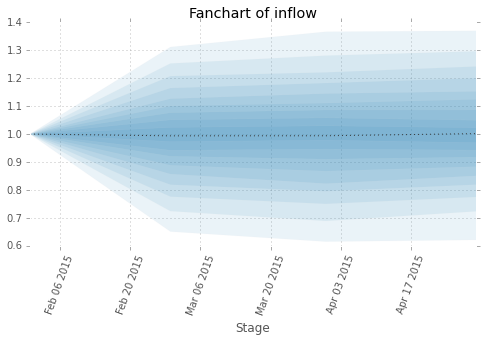

In [34]:
sim.inflow.fanchart(alpha=.1)

#### Spaghetti plots
Another nice way to visualize uncertainty is to plot each individual time series, but make the individual plots transparant. The result is similar to that of a fanchart only that we can still see the individual paths.

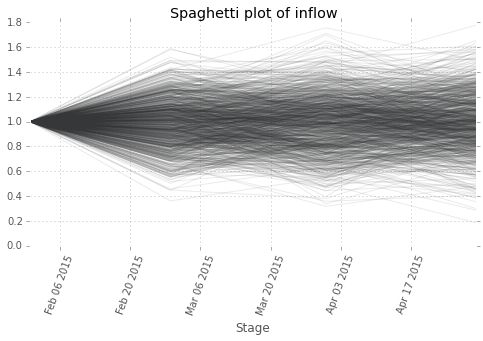

In [35]:
sim.inflow.spaghetti(alpha=.1)

##Optimizing a Stochastic Decision Problem
The *DynamicOptimizer* implememted in QUASAR builds on approximate dual dynamic programming (ADDP) as solution algorithm. ADDP combines nested Benders' decomposition with reinforcement learning as well as scenario reduction strategies to solve large-scale stochastic optimization problems.

###Calling the optimizer
We now pass the problem and our model of uncertainty, the AR model, into the dynamic optimizer. The optimizer internally builds an optimal discrete appproximation of the stochastic process, a so-called lattice. The quality of the result sometimes depends on the number of nodes per stage, so that we should provide the number of nodes for this discretization.

In [36]:
opt = DynamicOptimizer(problem, ar_model, num_nodes=50)
opt.solve()
opt.join()

The optimizer finishes automatically when the algorithm has converged. Let us grab the summary statistic of the optimization process and plot the duality gap.

      expReward  simReward  stdError  hyperplanes  numSolves  duration
iter                                                                  
78         5.98       5.69      0.35         1494      11837      0.00
79         5.98       5.72      0.35         1584      11989      0.00
80         5.98       5.64      0.32         1678      12141      0.00
81         6.52       5.65      0.33         1772      12293      0.00
82         5.98       5.81      0.11         1620      12445      0.00


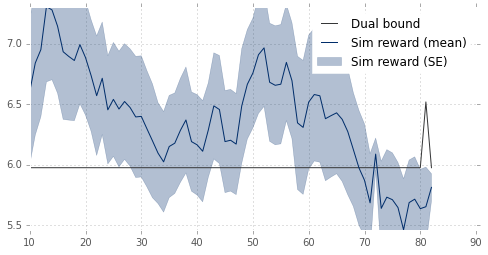

In [39]:
print opt.stats.tail()
opt.plot()

###Getting the Solution

In [40]:
pol = opt.policy

####The first stage solution

In [41]:
fs = pol.first_stage_solution()
print fs

# Reward: 0.0


# Decisions
{
 "release": 1.0, 
 "shortfall": 0.0, 
 "storage": 4.0
}
# Shadow prices
{
 "storage": -3.9982791847465333
}


####Simulating the optimal policy

In [42]:
pol = opt.policy
sim = pol.simulate(sample_size=100, process=ar_model)

All solution information is stored in Pandas dataframe which offers a whole universe of functions for data analysis.

In [43]:
sim[0:10]

rewards decision                           shadow_price  state
             rewards  release storage shortfall penalty      storage inflow
series stage                                                               
0      0        0.00     1.00    4.00      0.00     nan        -4.00   1.00
       1        1.16     0.21    4.88      0.29     nan        -4.00   1.09
       2        6.72     0.32    4.94      1.68     nan        -4.00   0.38
       3        2.14     2.00    3.46      0.00    2.14          nan   0.52
1      0        0.00     1.00    4.00      0.00     nan        -4.00   1.00
       1        1.38     0.16    4.88      0.34     nan        -4.00   1.04
       2        0.82     1.79    4.34      0.21     nan        -4.00   1.25
       3        2.40     2.00    3.40      0.00    2.40          nan   1.06
2      0        0.00     1.00    4.00      0.00     nan        -4.00   1.00
       1        2.00     0.00    4.85      0.50     nan        -4.00   0.85

Let us take a look at the distribution of storage levels over time.

In [44]:
sim.decision.storage.describe()

count   400.00
mean      4.14
std       0.56
min       2.45
25%       3.82
50%       4.00
75%       4.56
max       5.06
Name: storage, dtype: float64

A nice way to visualize uncertainty over time are fan charts, which render a sample of the same timer series as a shaded region. The plot is darker in areas with realizations of high probability and lighter in areas eith realizations of low probability.

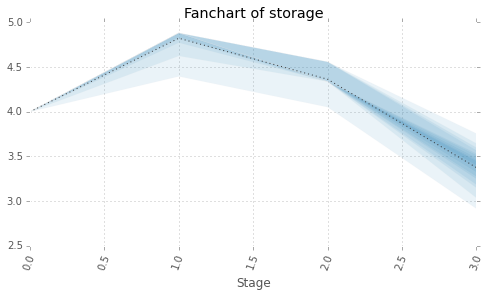

In [45]:
sim.decision.storage.fanchart()

If we are interested in the distribution of the total rewards, we can also take a look at the histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f4a748a50>]], dtype=object)

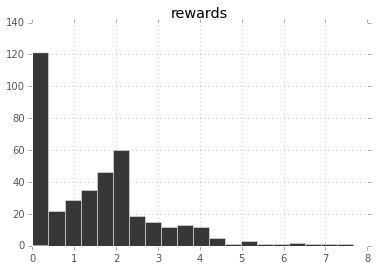

In [46]:
sim.rewards.hist(bins=20)

We can also take a look at how our autoregressive random inflows have evolved over time.